In [27]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs,scfunc
from lib.sim_functions import rand_scint_times
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

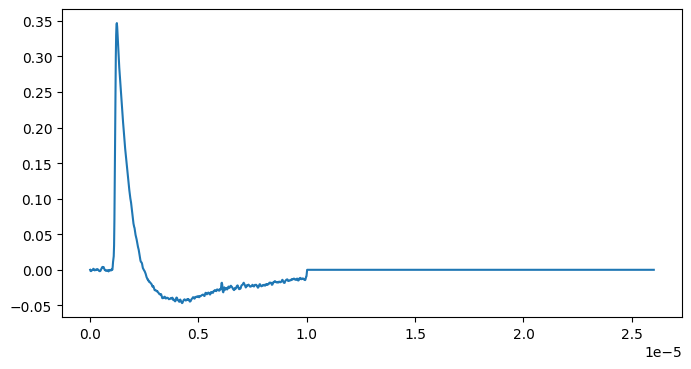

In [28]:
show = True

# Load data for wvf template
raw_SER = open("../larsoft/PDS/SPE_maritza.txt")
expand_array = 1000

# Generate empty array to import data
SER = np.asarray(raw_SER.readlines()).astype(float)
SER = np.append(np.asarray(SER),np.zeros(expand_array))

# Generate dict with required structure
my_run = dict()

my_run["NRun"] = [0]
my_run["NChannel"] = [0]

my_run[0] = dict()
my_run[0][0] = dict()
my_run[0][0]["ADC"] = [np.array(SER)]
my_run[0][0]["Sampling"] = 16e-9

if show == True:
    plt.figure(figsize=(8,4))
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0])
    plt.show()


Fitting wvf  0


Generated wvfs with key WienerDecSPE


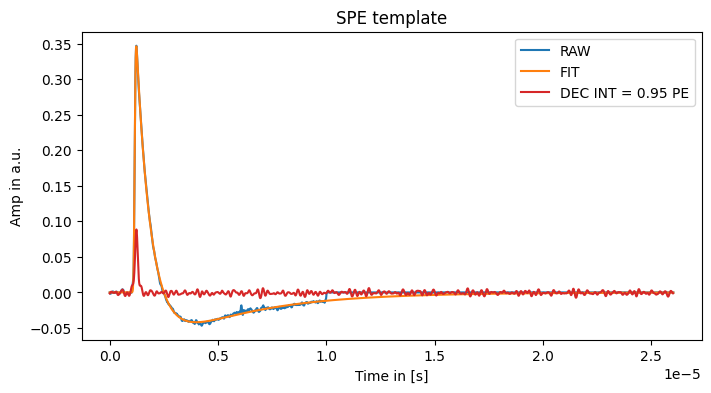

In [29]:
dec_label = "Wiener"
key = ["ADC","FitSC","DecSPE"]
opt = {
    "SHOW": False,
    "NOISE_AMP": 1,
    "FIX_EXP":True,
    "WIENER_BUFFER": 10,
    "FILTER": "WIENER",
    }

# One can substitute the template with a fit
fit_wvfs(my_run,"SC",1e-4,fit_range=[0,len(SER)-expand_array],OPT=opt)
max_idx = np.argmax(my_run[0][0]["FitSC"][0])
pre = len(my_run[0][0]["FitSC"][0][:max_idx])
post = len(my_run[0][0]["FitSC"][0][max_idx:])
deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution

if show == True:
    plt.figure(figsize=(8,4))
    plt.title("SPE template")
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    # plt.axvline(my_run[0][0]["Sampling"]*(len(SER)-expand_array),ls="--",c="grey")
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0],label="RAW")
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSC"][0])),my_run[0][0]["FitSC"][0],label="FIT")
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_label+"DecSPE"][0])),my_run[0][0][dec_label+"DecSPE"][0],c="tab:red",label="DEC INT = %.2f PE"%(np.sum(my_run[0][0][dec_label+"DecSPE"][0][50:100])))
    plt.legend()
    plt.show()

In [30]:
my_run[0][0]["McADC"] = []
MC_num = 1000
for i in range(MC_num):
    times = rand_scint_times(50,slow=6e-9,fast=1e-6,ratio=0.15)
    peaks = [];wvf = []

    times_array = np.linspace(0,20e-6,int(20e-6/my_run[0][0]["Sampling"])+1)
    wvf = np.zeros(pre+len(times_array)+post)

    # print(len(wvf))
    for t in times:
        this_peak = int((t-(t%my_run[0][0]["Sampling"]))/my_run[0][0]["Sampling"])
        peaks.append(this_peak)
        this_wvf = np.zeros(pre+this_peak)
        this_wvf = np.append(this_wvf,my_run[0][0]["FitSC"][0])
        this_wvf = np.append(this_wvf,np.zeros(len(wvf)-len(this_wvf)))
        wvf = wvf+this_wvf
    my_run[0][0]["McADC"].append(wvf)
my_run[0][0]["McNoiseADC"] = np.asarray(my_run[0][0]["McADC"])+np.random.normal(0,np.max(SER)*0.5,size=[len(my_run[0][0]["McADC"]),len(my_run[0][0]["McADC"][0])])
# my_run[0][0]["FitSC"][0] = my_run[0][0]["FitSC"][0][:len(my_run[0][0]["McNoiseADC"][0])]
# plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Fit_SC"][0])),my_run[0][0]["Fit_SC"][0])


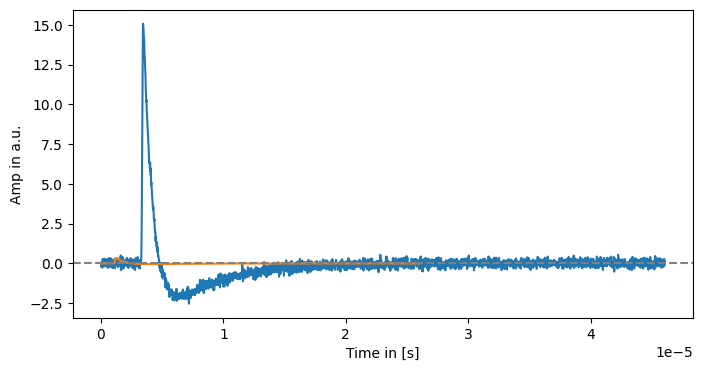

In [31]:
if show == True:
    plt.figure(figsize=(8,4))
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    num = np.random.randint(0,MC_num)
    # plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0],c="tab:green")
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),my_run[0][0]["McNoiseADC"][num],c="tab:blue")
    plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSC"][0])),my_run[0][0]["FitSC"][0],c="tab:orange")
    plt.axhline(0,c="grey",ls="--")
    plt.show()

In [32]:
KEY = ["McADC","FitSC","DecADC"]
OPT = {
    "NOISE_AMP": 1,
    "FIX_EXP":True,
    # "NORM":False,
    "WIENER_BUFFER": 200,
    "FILTER": "WIENER",
    # "THRLD": 1e-4
    }
# print(my_run[0][0][KEY[1]][0])
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)


RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF TEMPLATE
RAW WVF IS LONGER THAN WVF T

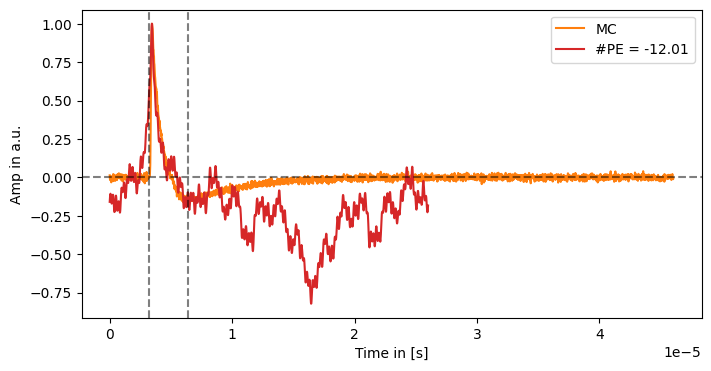

In [43]:
show = True
norm = True
raw_key = "McNoiseADC"
dec_key = "WienerDecNoiseADC"
low_int_limit = 200
high_int_limit = 400
if show == True:
    plt.figure(figsize=(8,4))
    plt.xlabel("Time in [s]")
    plt.ylabel("Amp in a.u.")
    my_run[0][0].keys()
    num = np.random.randint(0,MC_num)
    charge = np.sum(my_run[0][0][dec_key][num])
    if norm == True:
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][raw_key][num])),my_run[0][0][raw_key][num]/np.max(my_run[0][0][raw_key][num]),label="MC",c="tab:orange")
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_key][num])),my_run[0][0][dec_key][num]/np.max(my_run[0][0][dec_key][num]),label="#PE = %.2f"%charge,c="tab:red")
    else:
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][raw_key][num])),my_run[0][0][raw_key][num],label="MC",c="tab:orange")
        plt.plot(my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_key][num])),my_run[0][0][dec_key][num],label="#PE = %.2f"%charge,c="tab:red")
    plt.axhline(0,ls="--",alpha=0.5,c="black")
    plt.axvline(low_int_limit*my_run[0][0]["Sampling"],ls="--",alpha=0.5,c="black")
    plt.axvline(high_int_limit*my_run[0][0]["Sampling"],ls="--",alpha=0.5,c="black")
    plt.legend()
    # plt.semilogy()
    plt.show()

In [34]:
filter_type = "Gauss"
charge = np.sum(my_run[0][0][filter_type+"DecADC"][:,low_int_limit:high_int_limit],axis=1)
noise_charge = np.sum(my_run[0][0][filter_type+"DecNoiseADC"][:,low_int_limit:high_int_limit],axis=1)
plt.figure(figsize=(8,4))
plt.ylabel("Counts")
plt.xlabel("Charge in PE")
plt.hist(charge,bins=50,alpha=1,label="PE CLEAN SIGNAL")
plt.hist(noise_charge,bins=50,alpha=.75,label="PE NOISE SIGNAL")
plt.legend()
plt.show()

KeyError: 'GaussDecADC'